# AAE 450 Habitat Power Trade Study
## Noah Stockwell

### Last reviewed 3/31/2021

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
import numpy as np
import seaborn as sns

## Solar model

In [2]:
def solar_model(launch_cost, capacity, launches_per_year, launch_capacity_non_starship, starship=False, amt_before_starship=.25):
    year = np.linspace(0, 10, 2**10)
    cost = np.zeros(year.shape)
    day_capacity = cost.copy()
    night_capacity = cost.copy()
    
    lf = (1 + 6 / 28)
    
    tech_dev = 0
    procurement = lf * capacity * 0.53357 + 31.91107 + capacity * 24 * 5 * 8500 / 1e6
    mass = capacity * 24.83783 * lf + capacity * 120 * 1000 / 250
    
    tech_dev_horizon = 0
    procurement_horizon = 120 / capacity # 120 kW / year capable
    
    starship_introduction = 3
    launch_capacity_starship = 67500
    launch_cost_starship = 875 / launch_capacity_starship
    
    print(procurement)
    print(mass)
    
    def day_capacity_model(mass_on_moon):
        per_array_capacity = 25
        per_array_mass = per_array_capacity * 24.83783
        tot_arrays = np.ceil(capacity / per_array_capacity)
                
        arrays_allowed = np.ceil(mass_on_moon / mass * tot_arrays)
        
        if mass_on_moon != mass:
            incrimental_array_mass = min(per_array_mass, np.mod(mass_on_moon, mass / tot_arrays))


            num_complete_arrays_present = np.floor(incrimental_array_mass / per_array_mass)
            num_complete_arrays_present += max(0, arrays_allowed - 1)
        else:
            num_complete_arrays_present = tot_arrays
        
        # tot_array_mass_delivered = incrimental_array_mass + per_array_mass * max(0, arrays_allowed - 1)
        
        return num_complete_arrays_present * per_array_capacity
        
    
    def night_capacity_model(mass_on_moon):
        battery_capacity = .250 # kWh/kg
        
        per_array_capacity = 25
        per_array_mass = per_array_capacity * 24.83783
        tot_arrays = np.ceil(capacity / per_array_capacity)
        
        arrays_allowed = np.ceil(mass_on_moon / mass * tot_arrays)
        incrimental_array_mass = min(per_array_mass, np.mod(mass_on_moon, mass / tot_arrays))
        
        # num_complete_arrays_present = np.floor(incrimental_array_mass / per_array_mass)
        # num_complete_arrays_present += max(0, arrays_allowed - 1)
        
        tot_array_mass_delivered = incrimental_array_mass + per_array_mass * max(0, arrays_allowed - 1)
        
        battery_mass_delivered = mass_on_moon - tot_array_mass_delivered
        
        battery_capacity = (battery_mass_delivered * battery_capacity) / (5 * 24)
        
        return min(capacity, battery_capacity)
        
    
    ## Calculations
    tech_dev_mask = np.logical_and(0 <= year, year < tech_dev_horizon)
    procurement_mask = np.logical_and(tech_dev_horizon <= year, year < procurement_horizon)
    
    frac_year = year / tech_dev_horizon if tech_dev_horizon > 0 else 0
    cost += tech_dev * (.75 * tech_dev_mask * (frac_year) ** 2 + .25)
    cost[year > tech_dev_horizon] += tech_dev
    
    contract_issued = np.where(year > tech_dev_horizon)[0][0]
    contract_finished = np.where(year > tech_dev_horizon + procurement_horizon)[0][0]
    cost[contract_issued:contract_finished] += procurement * .25
    cost[contract_finished:] += procurement * .75
    
    # Launch calcs
    launches = np.arange(year[contract_finished], 10, 1 / launches_per_year)
    launch_capacity = launch_capacity_non_starship * np.ones(launches.shape)
    
    if starship:
        launch_capacity[launches > starship_introduction] = launch_capacity_starship
        launched_mass = np.cumsum(launch_capacity)
    
        last_falcon_launch = np.where(launched_mass > mass * amt_before_starship)[0][0]
        starship_cts = mass * (1 - amt_before_starship) / launch_capacity_starship
        
        on_falcon_launches = launched_mass < mass * amt_before_starship
        on_falcon_launches[:last_falcon_launch + 1] = True 
    
        for launch_num, launch_date in enumerate(launches[on_falcon_launches]):
            date_idx = np.where(year > launch_date)[0][0]

            if launch_num == 0:
                mass_on_vehicle = min(launch_capacity_non_starship, mass)
            else:
                mass_on_vehicle = min(launch_capacity_non_starship, mass - launched_mass[launch_num-1])

            cost[date_idx:] += launch_cost * mass_on_vehicle

            day_capacity[date_idx:] = day_capacity_model(min(mass, launched_mass[launch_num]))
            night_capacity[date_idx:] = night_capacity_model(min(mass, launched_mass[launch_num]))
            
        first_starship_launch = np.where(launches > starship_introduction)[0][0]
        
        starship_mass_delivered = 0
        starship_num = 0
        payload_to_deliver = mass * (1 - amt_before_starship)
        
        while starship_mass_delivered < payload_to_deliver:
            starship_num += 1
            mass_on_vehicle = min(launch_capacity_starship, payload_to_deliver - starship_mass_delivered)
            starship_mass_delivered += mass_on_vehicle
            
            date_idx = np.where(year > launches[first_starship_launch + starship_num])[0][0]
    
            cost[date_idx:] += launch_cost_starship * mass_on_vehicle

            day_capacity[date_idx:] = day_capacity_model(min(mass, starship_mass_delivered + mass * amt_before_starship))
            night_capacity[date_idx:] = night_capacity_model(min(mass, starship_mass_delivered + mass * amt_before_starship))
    else:
        launched_mass = launch_capacity * np.arange(1, launches.shape[0] + 1)

        last_launch = np.where(launched_mass > mass)[0][0]
        on_launches = launched_mass < mass
        on_launches[:last_launch + 1] = True
        
        for launch_num, launch_date in enumerate(launches[on_launches]):
                        
            date_idx = np.where(year > launch_date)[0][0]

            if launch_num == 0:
                mass_on_vehicle = min(launch_capacity_non_starship, mass)
            else:
                mass_on_vehicle = min(launch_capacity_non_starship, mass - launched_mass[launch_num-1])

            cost[date_idx:] += launch_cost * mass_on_vehicle

            day_capacity[date_idx:] = day_capacity_model(min(mass, launched_mass[launch_num]))
            night_capacity[date_idx:] = night_capacity_model(min(mass, launched_mass[launch_num]))
    
    return year, cost, day_capacity, night_capacity

## Make one Plot

365.49235571428574
102032.04442857143


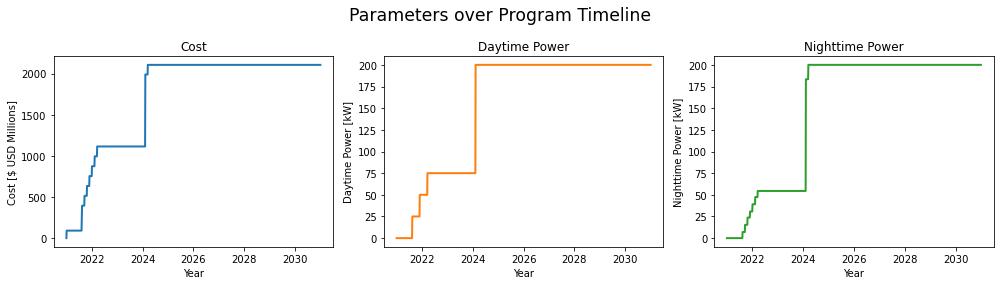

In [3]:
launch_cost = 30000

incrimental_val = 1250
rocket_vals = np.arange(15000, 100000 + incrimental_val, incrimental_val)

least_diff = np.abs(rocket_vals - launch_cost)
launch_cost_dollars = rocket_vals[least_diff.min() == least_diff]

color_vals = np.ones((rocket_vals.shape[0], 3))
color_vals[rocket_vals == launch_cost_dollars] = [0, 0, 0]
cmap = ListedColormap(color_vals, N=color_vals.shape[0])

# ts, cs, ss, bs = solar_model(launch_cost_dollars / 1e6, 200, 10, 4000)
ts, cs, ss, bs = solar_model(launch_cost_dollars / 1e6, 200, 10, 4000, True, .25)
# tn, cn, sn, bn = nuclear_model(launch_cost_dollars / 1e6, 175, 10, 4000)
# tc, cc, sc, bc = np.array(solar_model(launch_cost_dollars / 1e6, 175 / 2, 10, 4000)) + np.array(nuclear_model(launch_cost_dollars / 1e6, 175 / 2, 10, 4000))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(ts+2021, cs, color=sns.color_palette("tab10")[0], lw=2)
# ax.plot(tn+2021, cn)
# ax.plot(ts+2021, cc)
ax.set_ylabel('Cost [$ USD Millions]')
ax.set_xlabel('Year')
# ax.set_ylim([0, 4500])
ax.set_title('Cost')


ax = axes[1]
ax.plot(ts+2021, ss, color=sns.color_palette("tab10")[1], lw=2)
# ax.plot(tn+2021, sn)
# ax.plot(ts+2021, sc)
ax.set_ylabel('Daytime Power [kW]')
ax.set_xlabel('Year')
ax.set_title('Daytime Power')


ax = axes[2]
ax.plot(ts+2021, bs, color=sns.color_palette("tab10")[2], lw=2)
# ax.plot(tn+2021, bn)
# ax.plot(ts+2021, bc)
ax.set_ylabel('Nighttime Power [kW]')
ax.set_xlabel('Year')
ax.set_title('Nighttime Power')

fig.suptitle('Parameters over Program Timeline', size='xx-large')
fig.tight_layout()

# norm = Normalize(15000, 100000)
# fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=.05, aspect=60)

fig.savefig('parametersOverTimeline.jpg', dpi=180)

In [4]:
def nuclear_model(launch_cost, capacity, launches_per_year, launch_capacity):
    year = np.linspace(0, 10, 2**10)
    cost = np.zeros(year.shape)
    day_capacity = cost.copy()
    night_capacity = cost.copy()
    
    tech_dev = 1300
    procurement = capacity / 10 * 215
    mass = capacity / 10 * 3300
    
    tech_dev_horizon = 3.5
    procurement_horizon = 1
    
    def day_capacity_model(mass_on_moon):
        per_reactor_capacity = 10
        per_reactor_mass = 3300

        num_reactors = np.floor(mass_on_moon / per_reactor_mass)
        
        return min(capacity, num_reactors * per_reactor_capacity)
    
    def night_capacity_model(mass_on_moon):
        return day_capacity_model(mass_on_moon)
        
    
    ## Calculations
    tech_dev_mask = np.logical_and(0 <= year, year < tech_dev_horizon)
    procurement_mask = np.logical_and(tech_dev_horizon <= year, year < procurement_horizon)
    
    frac_year = year / tech_dev_horizon if tech_dev_horizon > 0 else 0
    cost += tech_dev * (.75 * tech_dev_mask * (frac_year) ** 2 + .25)
    cost[year > tech_dev_horizon] += tech_dev
    
    contract_issued = np.where(year > tech_dev_horizon)[0][0]
    contract_finished = np.where(year > tech_dev_horizon + procurement_horizon)[0][0]
    cost[contract_issued:contract_finished] += procurement * .25
    cost[contract_finished:] += procurement * .75
    
    launches = np.arange(year[contract_finished], 10, 1 / launches_per_year)
    launched_mass = launch_capacity * np.arange(1, launches.shape[0] + 1)
    
    last_launch = np.where(launched_mass > mass)[0][0]
    on_launches = launched_mass < mass
    on_launches[:last_launch + 1] = True
    
    for launch_num, launch_date in enumerate(launches[on_launches]):
        date_idx = np.where(year > launch_date)[0][0]
        
        if launch_num == 0:
            mass_on_vehicle = min(launch_capacity, mass)
        else:
            mass_on_vehicle = min(launch_capacity, mass - launched_mass[launch_num-1])
                
        cost[date_idx:] += launch_cost * mass_on_vehicle
        
        day_capacity[date_idx:] = day_capacity_model(min(mass, launched_mass[launch_num]))
        night_capacity[date_idx:] = night_capacity_model(min(mass, launched_mass[launch_num]))
    
    return year, cost, day_capacity, night_capacity

## Make Animation

In [5]:
# incrimental_val = 1250
# rocket_vals = np.arange(15000, 100000 + incrimental_val, incrimental_val)

# for val, launch_cost_dollars in enumerate(rocket_vals):
#     color_vals = np.ones((rocket_vals.shape[0], 3))
#     color_vals[rocket_vals == launch_cost_dollars] = [0, 0, 0]
#     cmap = ListedColormap(color_vals, N=color_vals.shape[0])
    
#     ts, cs, ss, bs = solar_model(launch_cost_dollars / 1e6, 175, 10, 4000)
#     tn, cn, sn, bn = nuclear_model(launch_cost_dollars / 1e6, 175, 10, 4000)
#     tc, cc, sc, bc = solar_model(launch_cost_dollars / 1e6, 175 / 2, 10, 4000) + nuclear_model(launch_cost_dollars / 1e6, 175 / 2, 10, 4000)

#     fig, axes = plt.subplots(1, 3, figsize=(14, 5))

#     ax = axes[0]
#     ax.plot(ts+2021, cs)
#     ax.plot(tn+2021, cn)
#     ax.plot()
#     ax.set_ylabel('Cost [$ USD Millions]')
#     ax.set_xlabel('Year')
#     ax.set_ylim([0, 6500])


#     ax = axes[1]
#     ax.plot(ts+2021, ss)
#     ax.plot(tn+2021, sn)
#     ax.set_ylabel('Daytime Power [kW]')
#     ax.set_xlabel('Year')


#     ax = axes[2]
#     ax.plot(ts+2021, bs)
#     ax.plot(tn+2021, bn)
#     ax.set_ylabel('Nighttime Power [kW]')
#     ax.set_xlabel('Year')

#     fig.tight_layout()

#     norm = Normalize(15000, 100000)
#     fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=.05, aspect=60)
    
#     fig.savefig(f'Animations/sim-{val+1}.jpg', dpi=300)
#     plt.close()

In [6]:
# import shutil

In [7]:
# new_v = rocket_vals.shape[0] + 1 + np.arange(rocket_vals.shape[0])
# old_v = np.arange(rocket_vals.shape[0], 0, -1)

# for idx in range(len(new_v)):
#     new_num = new_v[idx]
#     old_num = old_v[idx]
    
#     shutil.copy(f'Animations/sim-{old_num}.jpg', f'Animations/sim-{new_num}.jpg')